In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

import warnings
warnings.filterwarnings("ignore")

In [3]:
# --- 1. Load and Prepare Data ---
# Define the file path
file_path = '/content/drive/MyDrive/Reviews.csv'

df = pd.read_csv(file_path)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [5]:
df.shape

(568454, 10)

In [6]:
# Drop specified columns
columns_to_drop = ['ProductId', 'Id', 'ProfileName', 'UserId', 'HelpfulnessDenominator', 'HelpfulnessNumerator', 'Time']
df.drop(columns=columns_to_drop, inplace=True)


In [7]:
# Verify the columns are dropped
df.head()

,Score,Summary,Text
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,2,Cough Medicine,If you are looking for the secret ingredient i...
4,5,Great taffy,Great taffy at a great price. There was a wid...


In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [9]:
# Combine 'summary' and 'text' into a single feature, ensuring all text is properly handled
df['Summary'] = df['Summary'].fillna('').astype(str)
df['Text'] = df['Text'].fillna('').astype(str)
df['Combined_text'] = df['Summary'] + " " + df['Text']

In [10]:
# --- 2. Preprocess Text Data ---
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['Combined_text'])
sequences = tokenizer.texts_to_sequences(df['Combined_text'])
word_index = tokenizer.word_index

In [11]:
# Pad sequences to ensure uniform input size
max_length = 300
data = pad_sequences(sequences, maxlen=max_length)
data.shape

(568454, 300)

In [12]:
# --- 3. Handle Class Imbalance and Encode Labels ---
df['Score'] = df['Score'].fillna(df['Score'].mode()[0])
print("Class distribution before oversampling:", Counter(df['Score']))

ros = RandomOverSampler(random_state=42)
data_resampled, labels_resampled = ros.fit_resample(data, df['Score'])

print("Class distribution after oversampling:", Counter(labels_resampled))

Class distribution before oversampling: Counter({5: 363122, 4: 80655, 1: 52268, 3: 42640, 2: 29769})
Class distribution after oversampling: Counter({5: 363122, 1: 363122, 4: 363122, 2: 363122, 3: 363122})


In [13]:
# Encode labels (after oversampling)
label_encoder = LabelEncoder()
labels_resampled = label_encoder.fit_transform(labels_resampled)
labels_resampled = to_categorical(labels_resampled, num_classes=5)

In [14]:
# --- 4. Train-Test Split ---
x_train, x_val, y_train, y_val = train_test_split(
    data_resampled, labels_resampled, test_size=0.2, random_state=42
)

In [15]:
print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

x_train shape: (1452488, 300)
x_val shape: (363122, 300)
y_train shape: (1452488, 5)
y_val shape: (363122, 5)


In [16]:
# --- 5. Build LSTM Model with Embedding Layer (trained on your data) ---
embedding_dim = 128 # You can adjust this

model = Sequential()
model.add(Embedding(
    input_dim=len(word_index) + 1,  # Vocabulary size
    output_dim=embedding_dim,       # Embedding dimension
    input_length=max_length,       # Sequence length
    trainable=True                # Train embeddings on your data
))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [17]:
# summary()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 128)          17857408  
                                                                 
 lstm (LSTM)                 (None, 300, 128)          131584    
                                                                 
 dropout (Dropout)           (None, 300, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 18038725 (68.81 MB)
Trainable params: 1803

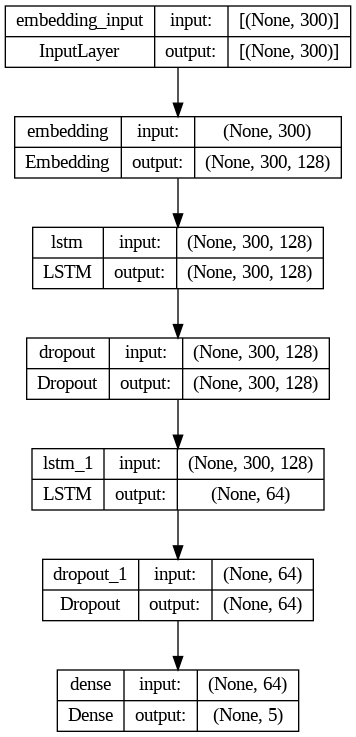

In [18]:
from tensorflow.keras.utils import plot_model

# Assuming your model is already created and named `model`

plot_model(model, to_file="Architecture of Amazon WDE-LSTM 5 scores.png", show_shapes=True)  # Adjust filename as needed

In [ ]:
# --- 8. Train the Model ---
import time
# Start time measurement
start_time = time.time()

# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_val, y_val))

# End time measurement
end_time = time.time()

# Calculate total time
print(f"Total training time: {end_time - start_time:.4f} seconds")

Epoch 1/5
45391/45391 [==============================] - 1601s 35ms/step - loss: 0.7144 - accuracy: 0.7158 - val_loss: 0.4639 - val_accuracy: 0.8263
Epoch 2/5
45391/45391 [==============================] - 1571s 35ms/step - loss: 0.3729 - accuracy: 0.8651 - val_loss: 0.3000 - val_accuracy: 0.8917
Epoch 3/5
45391/45391 [==============================] - 1576s 35ms/step - loss: 0.2583 - accuracy: 0.9087 - val_loss: 0.2361 - val_accuracy: 0.9154
Epoch 4/5
45391/45391 [==============================] - 1579s 35ms/step - loss: 0.2090 - accuracy: 0.9274 - val_loss: 0.2116 - val_accuracy: 0.9271
Epoch 5/5
45391/45391 [==============================] - 1581s 35ms/step - loss: 0.1822 - accuracy: 0.9372 - val_loss: 0.1858 - val_accuracy: 0.9355
Total training time: 7912.2443 seconds


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(x_val, y_val)
print(f'Validation Accuracy: {accuracy}')

11348/11348 [==============================] - 147s 13ms/step - loss: 0.1858 - accuracy: 0.9355
Validation Accuracy: 0.9354844689369202


In [ ]:
# Example prediction
new_texts = ["This product is excellent.", "Not what I expected."]
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_data = pad_sequences(new_sequences, maxlen=max_length)

predictions = model.predict(new_data)
predicted_labels = label_encoder.inverse_transform(predictions.argmax(axis=1))
print(predicted_labels)

1/1 [==============================] - 1s 826ms/step
[5 2]


In [ ]:
# Predict on the validation set
y_val_pred = model.predict(x_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(y_val, axis=1)

11348/11348 [==============================] - 132s 12ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
# Calculate metrics
accuracy = accuracy_score(y_val_true, y_val_pred_classes)
precision = precision_score(y_val_true, y_val_pred_classes, average='weighted')
recall = recall_score(y_val_true, y_val_pred_classes, average='weighted')
f1 = f1_score(y_val_true, y_val_pred_classes, average='weighted')
conf_matrix = confusion_matrix(y_val_true, y_val_pred_classes)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

print("\nClassification Report:\n", classification_report(y_val_true, y_val_pred_classes))



Accuracy: 0.9354844928150869
Precision: 0.9350721963866356
Recall: 0.9354844928150869
F1 Score: 0.9351886532461415

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98     72607
           1       0.97      0.99      0.98     72607
           2       0.96      0.97      0.96     72947
           3       0.89      0.86      0.88     72470
           4       0.88      0.89      0.88     72491

    accuracy                           0.94    363122
   macro avg       0.94      0.94      0.94    363122
weighted avg       0.94      0.94      0.94    363122



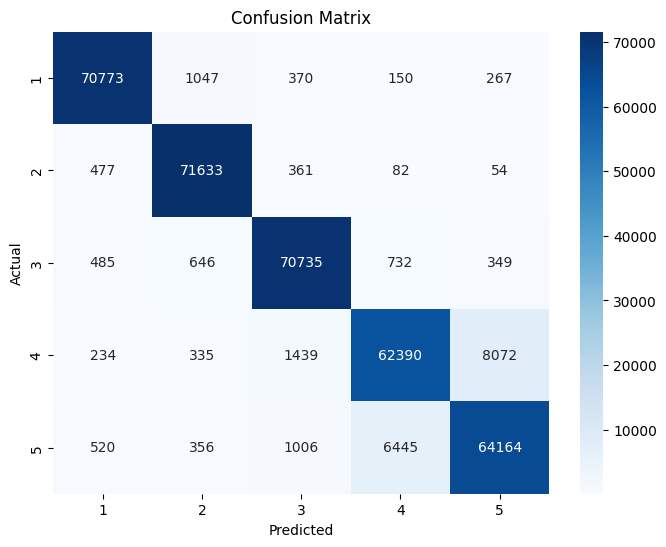

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()